In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
# function to create reference solution
def create_reference_solution(chromosome_length):
    # create Array with random mix of ones and zeros
    reference = np.random.randint(2, size=chromosome_length) 
    np.random.shuffle(reference)
    
    return reference

In [3]:
#example target array
print (create_reference_solution(20))

[1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0]


In [4]:
# function to create a starting population
def create_starting_population(individuals, chromosome_length):
    # Set up an initial 2d array of random zeros and ones, one row represents one individual
    population = np.random.randint(2, size=(individuals, chromosome_length))
    return population

In [5]:
# example starting population
print (create_starting_population(6, 20))

[[1 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0]
 [0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1]
 [0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 0 1 0 1 0]
 [1 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 1 1]
 [1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0]]


In [6]:
# function to calculate fitness of every individual
def calculate_fitness(reference, population):
    # create an array of True/False compared to reference
    identical_to_reference = population == reference
    # sum number of genes that are identical to the reference
    fitness_scores = identical_to_reference.sum(axis=1)
    
    return fitness_scores

In [7]:
# example reference solution with starting population and related fitness scores
reference = create_reference_solution(10)
print ('Reference solution: \n', reference)
population = create_starting_population(6, 10)
print ('\nStarting population: \n', population)
scores = calculate_fitness(reference, population)
print('\nFitness scores: \n', scores)

Reference solution: 
 [1 0 1 0 0 0 0 0 1 1]

Starting population: 
 [[0 1 0 1 0 0 1 1 1 1]
 [0 1 0 1 1 0 1 0 0 0]
 [0 0 1 1 0 0 0 1 0 1]
 [1 0 0 1 0 1 1 0 1 1]
 [1 1 1 1 0 0 0 0 1 1]
 [0 0 0 0 1 1 1 1 1 0]]

Fitness scores: 
 [4 2 6 6 8 3]


In [8]:
#function to select individuals by using tournament selection
def select_individual_by_tournament(population, scores):
    # get population size
    population_size = len(scores)
    
    # pick individuals for tournament
    fighter_1 = random.randint(0, population_size-1)
    fighter_2 = random.randint(0, population_size-1)
    
    # get fitness score for each individual
    fighter_1_fitness = scores[fighter_1]
    fighter_2_fitness = scores[fighter_2]
    
    # identify undividual with highest fitness
    # fighter 1 will win if scores are equal
    if fighter_1_fitness >= fighter_2_fitness:
        winner = fighter_1
    else:
        winner = fighter_2
    
    #return the chromsome of the winner
    return population[winner, :]

In [9]:
# example parent selection
# pick two parents and display them
parent_1 = select_individual_by_tournament(population, scores)
parent_2 = select_individual_by_tournament(population, scores)
print (parent_1)
print (parent_2)

[1 0 0 1 0 1 1 0 1 1]
[1 0 0 1 0 1 1 0 1 1]


In [10]:
def breed_by_crossover(parent_1, parent_2):
    # get length of chromosome
    chromosome_length = len(parent_1)
    
    # pick crossover point, avoding ends of chromsome
    crossover_point = random.randint(1,chromosome_length-1)
    
    # create children. np.hstack joins two arrays
    child_1 = np.hstack((parent_1[0:crossover_point],
                        parent_2[crossover_point:]))
    
    child_2 = np.hstack((parent_2[0:crossover_point],
                        parent_1[crossover_point:]))
    
    # return children
    return child_1, child_2

In [11]:
# example breeding children
# set up and score population
reference = create_reference_solution(15)
population = create_starting_population(100, 15)
scores = calculate_fitness(reference, population)

# pick two parents and display them
parent_1 = select_individual_by_tournament(population, scores)
parent_2 = select_individual_by_tournament(population, scores)

# get children
child_1, child_2 = breed_by_crossover(parent_1, parent_2)

# show output
print ('Parents')
print (parent_1)
print (parent_2)
print ('Children')
print (child_1)
print (child_2)

Parents
[0 0 0 1 1 1 1 1 1 0 0 0 1 1 0]
[0 1 0 1 0 0 1 1 1 0 1 0 1 0 0]
Children
[0 1 0 1 0 0 1 1 1 0 1 0 1 0 0]
[0 0 0 1 1 1 1 1 1 0 0 0 1 1 0]


In [12]:
# function to mutate population
def randomly_mutate_population(population, mutation_probability):
    
    # apply random mutation
        random_mutation_array = np.random.random(
            size=(population.shape))
        
        random_mutation_boolean = \
            random_mutation_array <= mutation_probability

        population[random_mutation_boolean] = \
        np.logical_not(population[random_mutation_boolean])
        
        # return mutation population
        return population

In [13]:
# example mutating population
# set up and score population
reference = create_reference_solution(15)
population = create_starting_population(100, 15)
scores = calculate_fitness(reference, population)

# pick two parents and display
parent_1 = select_individual_by_tournament(population, scores)
parent_2 = select_individual_by_tournament(population, scores)

# get children and make new population 
child_1, child_2 = breed_by_crossover(parent_1, parent_2)
population = np.stack((child_1, child_2))

# mutate population
mutation_probability = 0.1
print ("Population before mutation")
print (population)
population = randomly_mutate_population(population, mutation_probability)
print ("Population after mutation")
print (population)

Population before mutation
[[1 0 1 0 0 0 0 0 0 1 0 0 0 1 1]
 [0 0 1 1 0 1 0 1 0 1 1 1 1 0 1]]
Population after mutation
[[1 0 1 0 0 0 0 0 0 1 0 0 0 1 1]
 [0 0 1 1 0 1 0 1 0 1 1 1 1 0 1]]


Starting best score, percent target: 58.7
End best score, percent target: 100.0


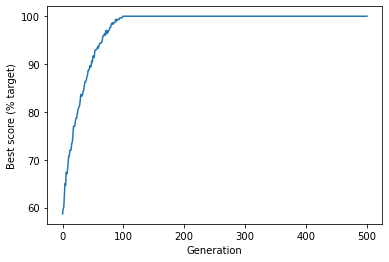

In [14]:
# main algorithm code
# set general parameters
chromosome_length = 300
population_size = 500
maximum_generation = 500
best_score_progress = [] # tracks progress

# create reference solution 
reference = create_reference_solution(chromosome_length)

# create starting population
population = create_starting_population(population_size, chromosome_length)

# display best score in starting population
scores = calculate_fitness(reference, population)
best_score = np.max(scores)/chromosome_length * 100
print ('Starting best score, percent target: %.1f' %best_score)

# add starting best score to progress tracker
best_score_progress.append(best_score)

# going through the generations of genetic algorithm
for generation in range(maximum_generation):
    # create an empty list for new population
    new_population = []
    
    # create new popualtion generating two children at a time
    for i in range(int(population_size/2)):
        parent_1 = select_individual_by_tournament(population, scores)
        parent_2 = select_individual_by_tournament(population, scores)
        child_1, child_2 = breed_by_crossover(parent_1, parent_2)
        new_population.append(child_1)
        new_population.append(child_2)
    
    # replace the old population with the new one
    population = np.array(new_population)
    
    # apply mutation
    mutation_rate = 0.002
    population = randomly_mutate_population(population, mutation_rate)

    # score best solution, and add to tracker
    scores = calculate_fitness(reference, population)
    best_score = np.max(scores)/chromosome_length * 100
    best_score_progress.append(best_score)

# GA has completed required generation number
print ('End best score, percent target: %.1f' %best_score)

# plot progress
%matplotlib inline
plt.plot(best_score_progress)
plt.xlabel('Generation')
plt.ylabel('Best score (% target)')
plt.show()